## Final Project Submission

Please fill out:
* Student name: Joseph Husney
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [57]:
# import modules needed for project
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from tqdm import tqdm

In [2]:
# Telling pandas to allow me to see all rows and columns without summarizing
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
# Get all movie id's before 2019
df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
print(len(df))
print(df.columns)
movie_ids = []
for index, rows in df.iterrows():
    if int(df['release_date'][0].split('-')[0]) < 2019:
        my_list = [rows.id]
        movie_ids.append(my_list)
print(movie_ids)

26517
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')


[[12444], [10191], [10138], [862], [27205], [32657], [19995], [10193], [20352], [38055], [863], [12155], [27578], [38757], [41439], [24021], [20504], [52371], [2502], [11324], [2501], [37834], [10140], [41233], [34544], [45269], [9737], [10196], [34851], [37799], [38234], [568], [95], [2503], [18823], [34806], [20662], [35019], [10192], [37735], [27022], [22538], [38365], [239], [41283], [7978], [44048], [44214], [44683], [61979], [23759], [27581], [23168], [20533], [20526], [9543], [9994], [7980], [705], [44264], [43947], [23483], [51888], [27576], [47626], [26389], [40662], [42949], [23023], [23631], [25376], [35056], [41733], [31867], [43641], [28874], [38575], [33217], [29427], [33613], [39451], [39514], [22971], [22894], [37933], [25195], [38408], [24253], [38363], [44244], [22972], [30061], [23169], [44115], [47533], [43593], [37861], [12201], [35552], [32856], [43539], [50393], [26388], [11645], [41135], [38745], [41216], [23172], [16290], [13078], [15357], [10664], [51170], [38

In [4]:
# Getting so far info about 1000 movies based on 1000 id's that I got from dataset I was given
# There are 26 thousand movies but it takes very long
movie_info = []
for id_ in movie_ids[:100]:
    url = f"https://api.themoviedb.org/3/movie/{id_[0]}?api_key=34017996022f64249a86491295577f6b&language=en-US"
    response = requests.get(url)
    movie_info.append(response.json())
df = pd.DataFrame.from_dict(movie_info)
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/fXRXpzxUApE3OuXhIqsdavQjCVa.jpg,"{'id': 1241, 'name': 'Harry Potter Collection'...",250000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.warnerbros.com/movies/harry-potter...,12444,tt0926084,en,Harry Potter and the Deathly Hallows: Part 1,"Harry, Ron and Hermione walk away from their l...",34.464,/iGoXIpQb7Pot00EEdwpwPajheZ5.jpg,"[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-10-17,954305868,146,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,One Way… One Fate… One Hero.,Harry Potter and the Deathly Hallows: Part 1,False,7.8,13118
1,False,/kxklJL1v8MYEU5xdU6W5VvmBwVz.jpg,"{'id': 89137, 'name': 'How to Train Your Drago...",165000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 12, 'na...",http://www.howtotrainyourdragon.com/,10191,tt0892769,en,How to Train Your Dragon,As the son of a Viking leader on the cusp of m...,34.040,/ygGmAO60t8GyqUo9xYeYxSZAR3b.jpg,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-10,494878759,100,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,One adventure will change two worlds,How to Train Your Dragon,False,7.8,9190
2,False,/hCVQPB77eXBGh9abVdrWtKpKgkN.jpg,"{'id': 131292, 'name': 'Iron Man Collection', ...",200000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/iron-man-2,10138,tt1228705,en,Iron Man 2,With the world now aware of his dual life as t...,35.288,/6WBeq4fCfn7AN0o21W9qNcRF2l9.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-28,623933331,124,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"It's not the armor that makes the hero, but th...",Iron Man 2,False,6.8,14730
3,False,/lxD5ak7BOoinRNehOCA85CQ8ubr.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",34.421,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.9,12704
4,False,/s3TBrRGB1iav7gFOCNx3H31MoES.jpg,None,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",http://inceptionmovie.warnerbros.com/,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",65.591,/9gk7adHYeDvHkCSEqAvQNLV5Uge.jpg,"[{'id': 923, 'logo_path': '/5UQsZrfbfG2dYJbx8D...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2010-07-15,825532764,148,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Your mind is the scene of the crime.,Inception,False,8.3,26607
5,False,/sEyNWq9985lyUrwayWnvicT4FHA.jpg,"{'id': 179919, 'name': 'Percy Jackson Collecti...",95000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.percyjacksonthemovie.com,32657,tt0814255,en,Percy Jackson & the Olympians: The Lightning T...,"Accident prone teenager, Percy discovers he's ...",27.513,/brzpTyZ5bnM7s53C1KSk1TmrMO6.jpg,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-02-01,226497209,119,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Worlds Collide,Percy Jackson & the Olympians: The Lightning T...,False,6.2,5276
6,False,/eS8rJ1KzRNBewx9MduiSHM4kr7S.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",44.209,

In [17]:
test = df['genres'][0]
test

[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}]

In [20]:
def seperate_genres(test):
    genres = []
    for genre in test:
            genres.append(genre['name'])
    return genres

In [22]:
genres = []
for i in range(0,100):
    genres.append(seperate_genres(df['genres'][i]))

In [23]:
genres

[['Adventure', 'Fantasy'],
 ['Fantasy', 'Adventure', 'Animation', 'Family'],
 ['Adventure', 'Action', 'Science Fiction'],
 ['Animation', 'Comedy', 'Family'],
 ['Action', 'Science Fiction', 'Adventure'],
 ['Adventure', 'Fantasy', 'Family'],
 ['Action', 'Adventure', 'Fantasy', 'Science Fiction'],
 ['Animation', 'Family', 'Comedy'],
 ['Animation', 'Family'],
 ['Animation', 'Action', 'Comedy', 'Family', 'Science Fiction'],
 ['Animation', 'Comedy', 'Family'],
 ['Family', 'Fantasy', 'Adventure'],
 ['Thriller', 'Adventure', 'Action'],
 ['Animation', 'Family'],
 ['Horror', 'Crime'],
 ['Adventure', 'Fantasy', 'Drama', 'Romance'],
 ['Action', 'Thriller', 'Science Fiction'],
 ['Music', 'Romance'],
 ['Action', 'Drama', 'Thriller'],
 ['Drama', 'Thriller', 'Mystery'],
 ['Action', 'Drama', 'Mystery', 'Thriller'],
 ['Action', 'Comedy'],
 ['Adventure', 'Family', 'Fantasy'],
 ['Drama', 'Romance'],
 ['Thriller', 'Action', 'Adventure', 'Comedy', 'Crime'],
 ['Drama', 'History'],
 ['Action', 'Comedy', 'Crim

In [25]:
type(genres[0])

list

In [ ]:
# df_nulls = df.isna()['release_date']
# df_nulls = df_nulls[lambda x: x == True]
# df_nulls
# should get
# 182    True
# 864    True
# need to delete those rows becase they aren't allowing me to view what I want to view

In [ ]:
# df = df.drop([182])

In [ ]:
# df['release_date']

In [ ]:
# df

In [16]:
genres = []
for item in df['genres']:
    for genre in item:
        genres.append(genre['name'])
genres
#df['genres'][0][0]['id']

['Adventure',
 'Fantasy',
 'Fantasy',
 'Adventure',
 'Animation',
 'Family',
 'Adventure',
 'Action',
 'Science Fiction',
 'Animation',
 'Comedy',
 'Family',
 'Action',
 'Science Fiction',
 'Adventure',
 'Adventure',
 'Fantasy',
 'Family',
 'Action',
 'Adventure',
 'Fantasy',
 'Science Fiction',
 'Animation',
 'Family',
 'Comedy',
 'Animation',
 'Family',
 'Animation',
 'Action',
 'Comedy',
 'Family',
 'Science Fiction',
 'Animation',
 'Comedy',
 'Family',
 'Family',
 'Fantasy',
 'Adventure',
 'Thriller',
 'Adventure',
 'Action',
 'Animation',
 'Family',
 'Horror',
 'Crime',
 'Adventure',
 'Fantasy',
 'Drama',
 'Romance',
 'Action',
 'Thriller',
 'Science Fiction',
 'Music',
 'Romance',
 'Action',
 'Drama',
 'Thriller',
 'Drama',
 'Thriller',
 'Mystery',
 'Action',
 'Drama',
 'Mystery',
 'Thriller',
 'Action',
 'Comedy',
 'Adventure',
 'Family',
 'Fantasy',
 'Drama',
 'Romance',
 'Thriller',
 'Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Drama',
 'History',
 'Action',
 'Comedy',
 'Cri

In [42]:
profit_by_genre = df.loc[:,['id','budget', 'revenue']]
profit_by_genre

,id,budget,revenue
0,12444,250000000,954305868
1,10191,165000000,494878759
2,10138,200000000,623933331
3,862,30000000,373554033
4,27205,160000000,825532764
5,32657,95000000,226497209
6,19995,237000000,2787965087
7,10193,200000000,1066969703
8,20352,69000000,543513985
9,38055,130000000,321885765


In [47]:
def extract_genre(genres, index):
    
    return [item[index] for item in genres] 

In [48]:
profit_by_genre['genre1'] = extract_genre(genres,0)

In [49]:
profit_by_genre['genre2'] = extract_genre(genres,1)

IndexError: list index out of range

In [50]:
profit_by_genre

,id,budget,revenue,genre1
0,12444,250000000,954305868,Adventure
1,10191,165000000,494878759,Fantasy
2,10138,200000000,623933331,Adventure
3,862,30000000,373554033,Animation
4,27205,160000000,825532764,Action
5,32657,95000000,226497209,Adventure
6,19995,237000000,2787965087,Action
7,10193,200000000,1066969703,Animation
8,20352,69000000,543513985,Animation
9,38055,130000000,321885765,Animation


In [52]:
q = """SELECT
        id, budget, revenue, genre1
     FROM
        profit_by_genre
     WHERE budget > 0 AND revenue > 0
     """
profit_by_genre = pysqldf(q)

In [53]:
profit_by_genre

,id,budget,revenue,genre1
0,12444,250000000,954305868,Adventure
1,10191,165000000,494878759,Fantasy
2,10138,200000000,623933331,Adventure
3,862,30000000,373554033,Animation
4,27205,160000000,825532764,Action
5,32657,95000000,226497209,Adventure
6,19995,237000000,2787965087,Action
7,10193,200000000,1066969703,Animation
8,20352,69000000,543513985,Animation
9,38055,130000000,321885765,Animation


In [54]:
profit_by_genre['profit'] = profit_by_genre['revenue']-profit_by_genre['budget']

In [74]:
q = """select genre1, avg(profit) as average_profit
        from profit_by_genre
        group by genre1
        order by average_profit desc"""
profit_per_genre = pysqldf(q)

In [75]:
profit_per_genre

,genre1,average_profit
0,Family,8.254671e+08
1,Animation,3.773397e+08
2,Adventure,2.489953e+08
3,Action,2.418672e+08
4,Drama,1.631177e+08
5,Comedy,1.343208e+08
6,Fantasy,1.081970e+08
7,Thriller,8.676067e+07
8,Horror,7.903455e+07
9,Crime,3.730006e+07


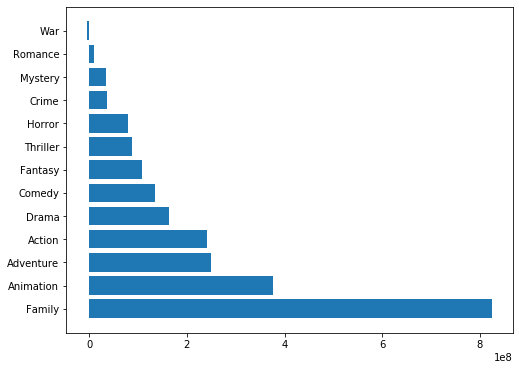

In [78]:
x = profit_per_genre['genre1']
y = profit_per_genre['average_profit']
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(x, y)
plt.show()